<a href="https://colab.research.google.com/github/AntonioCCosta/DPG_PhysicsBehavior_2026/blob/main/notebooks/notebook_2_toy_dw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physics of Behavior Tutorial II - Part 2

In this session, we will expand on the semi-analytic calculations of [Notebook 1](https://colab.research.google.com/github/AntonioCCosta/DPG_PhysicsBehavior_2026/blob/main/notebooks/notebook_1_theory_dw.ipynb), and explore how to approximate the transfer operator directly from data simulated from the Langevin dynamics of a particle in a double well.

Before we start, let's load the environment and the repository

In [1]:
# Environment setup
!pip install -q -r https://raw.githubusercontent.com/AntonioCCosta/DPG_PhysicsBehavior_2026/main/requirements.txt

In [2]:
import os

if not os.path.exists("DPG_PhysicsBehavior_2026"):
    !git clone https://github.com/AntonioCCosta/DPG_PhysicsBehavior_2026.git
else:
    %cd DPG_PhysicsBehavior_2026
    !git pull
    %cd ..

import sys, platform
print("Python:", sys.version)
print("Platform:", platform.platform())

print('Import utils packages')

import h5py
import numpy as np
np.random.seed(0)
import numpy.ma as ma
sys.path.append('./DPG_PhysicsBehavior_2026/utils')
import operator_calculations as op_calc
import delay_embedding as embed
import partition_methods as cl
import coarse_graining as cgm
import matplotlib.pyplot as plt

/content/DPG_PhysicsBehavior_2026
Already up to date.
/content
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.113+-x86_64-with-glibc2.35
Import utils packages


## Stochastic dynamics on a 1d double well

In [Notebook 1](https://colab.research.google.com/github/AntonioCCosta/DPG_PhysicsBehavior_2026/blob/main/notebooks/notebook_1_theory_dw.ipynb), we directly used the analytical expression to solve the Fokker-Planck equation using a finite-difference approach. However, in most real world scenarios, the equations of motion are unavailable, and instead we only have access to a finite set of observations. Here, we will see how we can directly approximate the transfer operator and its eigenspectrum directly from observations.

Let's consider again overdamped Langevin dynamics on a potential landscape,

$$
\dot{x}(t) = -\partial_x V(x) + \sqrt{2 T_x}\,\eta(t),
\qquad \langle \eta(t)\eta(t') \rangle = \delta(t-t').
$$

Where the potential landscape is given by of a double well type:

$$
V(x) = \frac{x^4}{4} -\mu \frac{x^2}{2}
$$

Let us get started by making some simulations using the Euler-Maruyama scheme as in Notebook 1.

In [3]:
## this is the code for simulations, but we'll just load them to be fast

# from numba import jit,prange
# @jit(nopython=True, parallel=True)
# def simulate_dw(x0s,mu, Tx, dt, max_iters,downsampling):
#     n_sims = len(x0s)
#     sims = np.zeros((n_sims, int(max_iters/downsampling)))
#     for ks in prange(n_sims):
#         x0 = x0s[ks]
#         x = x0
#         for i in range(max_iters):
#             new_x = x + (-x**3+mu*x) * dt + np.sqrt(2 * Tx) * np.random.normal(0, np.sqrt(dt))
#             x = new_x
#             if i%downsampling==0:
#                 sims[ks, int(i/downsampling)] = x
#     return sims

# Tx=3e-1 #temperature
# T = 1000 #simulation time
# dt = 5e-4 #simulation integration timescale
# max_iters=int(T/dt)
# final_dt = 1e-1 #sampling time
# downsampling = int(final_dt/dt)
# n_sims = 500 #number of simulations
# x0s = np.random.uniform(-1,1,n_sims)
# mu=1
# sims = simulate_dw(x0s,mu, Tx, dt, max_iters,downsampling)

# f= h5py.File('./DPG_PhysicsBehavior_2026/data/dw_sims.h5','w')
# f.create_dataset('sims',data=sims)
# f.create_dataset('final_dt',data=final_dt)
# f.create_dataset('T',data=T)
# f.create_dataset('sim_dt',data=dt)
# f.create_dataset('mu',data=mu)
# f.create_dataset('Tx',data=Tx)
# f.close()

In [4]:
#To save time, you can directly load example simulations:
f= h5py.File('./DPG_PhysicsBehavior_2026/data/dw_sims.h5','r')
sims = f['sims'][()] #simulations
final_dt = f['final_dt'][()] #sampling time
sim_dt = f['sim_dt'][()] #simulation integration timescale
T = f['T'][()] #simulation time
mu = f['mu'][()] #mu parameter
Tx = f['Tx'][()] #temperature
f.close()
print(mu, Tx)

1 0.3


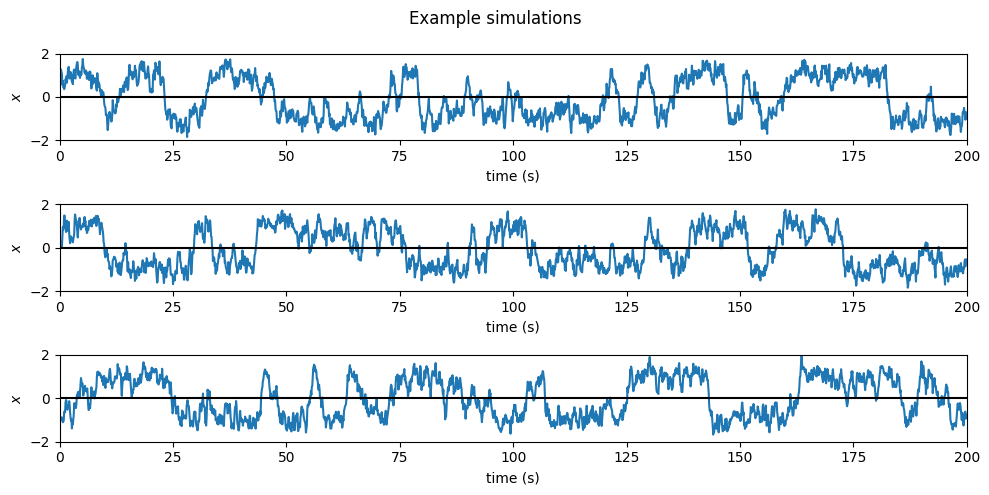

In [5]:
n_sims=sims.shape[0]
plt.figure(figsize=(10,5))
plt.suptitle('Example simulations')
n_samples=3
T_to_plot=2000
random_indices = np.random.randint(0,n_sims,n_samples)
random_sims = sims[random_indices][:,:T_to_plot]
for k in range(n_samples):
  plt.subplot(3,1,k+1)
  plt.plot(np.arange(T_to_plot)*final_dt,random_sims[k])
  plt.axhline(0,c='k')
  plt.ylim(-2,2)
  plt.ylabel(r'$x$')
  plt.xlabel('time (s)')
  plt.xlim(0,T_to_plot*final_dt)
plt.tight_layout()
plt.show()


## Estimating the transition matrix from data

The finite time operator $P_\tau$ introduced in [Notebook 1](https://colab.research.google.com/github/AntonioCCosta/DPG_PhysicsBehavior_2026/blob/main/notebooks/notebook_1_theory_dw.ipynb) effectively captures how probability mass flows across state space over a finite time.


We can emulate this by partitioning the state space into discrete regions and estimating how often trajectories move between them: in the limit of small partitions and large data, this approximation converges directly to $P_\tau$. This idea underlies many modern data-driven approaches, including Markov state models in molecular dynamics and diffusion maps in machine learning (see e.g. Bowman, Pande, Frank Noé. An introduction to Markov state models and their application to long timescale molecular simulation 2013; Coifman Lafon. Diffusion maps. Applied and computational harmonic analysis 2006).


The approach of partitioning the domain and directly counting transitions is called the Ulam-Galerkin method, which is guaranteed to approximate $P_\tau$ strongly in the limit of vanishing partition size and infinite trajectory data (see e.g., Bollt, Santitissadeekorn. Applied and computational measurable dynamics. 2013). Technically speaking, the Galerkin projection takes the infinite dimensional operator onto an $N\times N$ operator of finite rank by truncating an infinite dimensional set of basis functions at a finite $N$.

Ulam's method uses characteristic functions as the basis for this projection,

$$
\zeta_i(x) = \begin{cases}
    1, & \text{for $x \in s_i$}\\
    0, & \text{otherwise}
    \end{cases}.
$$

We thus partition the space into $N$ connected sets with nonempty and disjoint interior that covers $M$: $M = \cup_{i=1}^N s_i$, and approximate the transfer operator as a Markov chain by counting transitions from $s_i$ to $s_j$ in a finite time $\tau$. Given T observations, a set of $N$ partitions, and a transition time $\tau$, we compute

$$
C_{ij}(\tau) = \sum_{t=0}^{T-\tau}\zeta_i(x(t))\zeta_j(x(t+\tau)),
$$

which ammounts to counting how often the system moves from one region of state space to another over a time lag $\tau$. The maximum likelihood estimator of the transition matrix is obtained by simply row normalizing the count matrix,

$$
P_{ij}(\tau) = \frac{C_{ij}(\tau)}{\sum_j C_{ij}(\tau)}.
$$


And so to estimate $P_{ij}$ we need to define partitions $s_i$. To do that in a way that generalizes to higher dimensions, we will use the k-means algorithm to identify $N$ Voronoi cells directly from the sampled data. Rather than using a uniform grid, k-means constructs an adaptive partition that concentrates resolution where data density is highest. This improves statistical efficiency and naturally generalizes to higher-dimensional state spaces, where regular binning becomes impractical.

---

Given a discrete partition of state space, we can then estimate the transition matrix. We here use a delay of $\tau=0.1\text{s}$, which is smaller than the transition time between wells, but also long enough to enable transitions out of a single partition $s_i$. We will return to the question of $\tau$ selection at the end.

As discussed in [Notebook 1](https://colab.research.google.com/github/AntonioCCosta/DPG_PhysicsBehavior_2026/blob/main/notebooks/notebook_1_theory_dw.ipynb), the spectrum of the transfer operator encodes the characteristic relaxation timescales of the system. Eigenvalues close to 1 correspond to slowly decaying modes and therefore identify long-lived dynamical structures, while smaller eigenvalues represent fast microscopic fluctuations. We can use this to assess whether there is a separation of timescales and the presence of metastable states.

As you can see below, the slowest implied timescale of the inferred transition matrix, $t^\text{imp}_2 = -\tau/\log(\lambda_2(\tau))$ match the theoretical predictions obtained from Kramers' escape rate theory. In addition, the remaining timescales correspond relaxation timescales inside a single well, which is at most $\sim 1\,\text{s}$, much faster than the transitions between wells (see [Notebook1](https://colab.research.google.com/github/AntonioCCosta/DPG_PhysicsBehavior_2026/blob/main/notebooks/notebook_1_theory_dw.ipynb))


In [6]:
# this is the code to compute the discrete labels for each state space point. We will just load the result

# print('Parititon state space')
# N=1000
# #labels_all is an array with the partition that each point in the time series belongs to
# #centers is the centroid of each k-means cluster
# labels_all,centers = cl.kmeans_partition(np.hstack(sims).reshape(-1,1),N,batchsize=10000,return_centers=True)


# f= h5py.File('./DPG_PhysicsBehavior_2026/data/dw_labels.h5','w')
# f.create_dataset('labels_all',data=labels_all)
# f.create_dataset('centers',data=centers)
# f.create_dataset('N',data=N)
# f.close()

In [7]:
print('Parititon state space')
#labels_all is an array with the partition that each point in the time series belongs to
#centers is the centroid of each k-means cluster
f= h5py.File('./DPG_PhysicsBehavior_2026/data/dw_labels.h5','r')
N = f['N'][()]
labels_all = f['labels_all'][()]
centers = f['centers'][()]
f.close()


print('Estimate transition matrix and eigenspectrum')
delay=1
P_emp = op_calc.transition_matrix(labels_all,delay)
R = op_calc.get_reversible_transition_matrix(P_emp) #ensure reversibility
eigvals_emp,eigvecs_emp = op_calc.sorted_spectrum(R,k=2)
timp=-delay*final_dt/np.log(eigvals_emp[1].real)

print('estimated slowest timescale: {:.4f}s'.format(timp))

def kramers_rate(mu, Tx):
    # Well minimum
    x_m = np.sqrt(mu)
    # Barrier top
    x_s = 0.0

    V = lambda x,mu: x**4/4-mu*x**2/2

    # Second derivatives
    Vpp_m = 3 * x_m**2 - mu  # V''(x_m)
    Vpp_s = 3 * x_s**2 - mu  # V''(x_s)

    # Barrier height
    DeltaV = V(x_s, mu) - V(x_m, mu)

    # Kramers rate (overdamped, 1D)
    k = np.sqrt(abs(Vpp_s) * Vpp_m) / (2 * np.pi) * np.exp(-DeltaV / Tx)
    return k

print('analytical slow timescale: {:.4f}s'.format(0.5/kramers_rate(mu,Tx))) # the factor of 2 comes from the fact that we have a symmetric double well, see notebook_1_theory_dw.ipynb

Parititon state space
Estimate transition matrix and eigenspectrum
estimated slowest timescale: 4.1657s
analytical slow timescale: 5.1115s


We can also compare this with the transition rates obtained from the data

In [8]:
def state_lifetime(states,tau):
    durations=[]
    for state in np.sort(np.unique(states.compressed())):
        gaps = states==state
        gaps_boundaries = np.where(np.abs(np.diff(np.concatenate([[False], gaps, [False]]))))[0].reshape(-1, 2)
        durations.append(np.hstack(np.diff(gaps_boundaries))*tau)
    return durations

xs = np.hstack(sims)
states = ma.zeros(xs.shape)
states[xs>0]=1
states[xs==0]=ma.masked #mask if state is exactly at the boundary (super rare!)
durs = np.hstack(state_lifetime(states,final_dt))

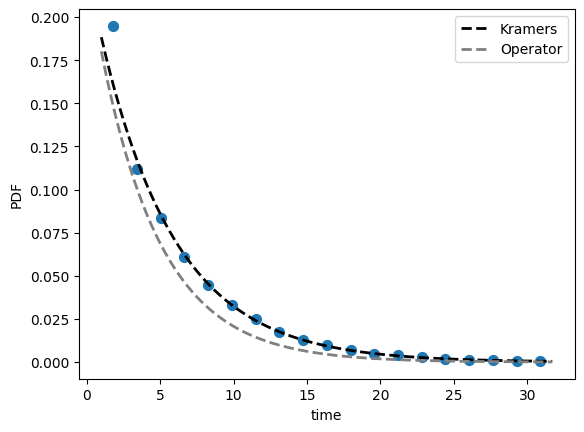

In [9]:
tmin=1
tmax=np.percentile(durs,99.9)
freqs,bin_edges = np.histogram(durs, bins=np.linspace(tmin,tmax,20), density=True)
centers_t = (bin_edges[1:]+bin_edges[:-1])/2
plt.scatter(centers_t,freqs,marker='o',s=50)
times = np.linspace(tmin,tmax,100)
_,b=np.polyfit(centers_t,np.log(freqs),1) #just to get the offset
rate = 2*kramers_rate(mu,Tx) #2x because it's only the time to the boundary
plt.plot(times,np.exp(b)*np.exp(-rate*times),c='k',lw=2,ls='--',label=r'Kramers')
rate = 1/timp # the match with the simulations would get better with more data
plt.plot(times,np.exp(b)*np.exp(-rate*times),c='gray',lw=2,ls='--',label=r'Operator')
# plt.yscale('log')
plt.ylabel('PDF')
plt.xlabel('time')
plt.legend()
plt.show()

## Slow modes

Besides the slowest timescale matching the expectation from our analytical analysis, the inferred slow eigenvector $\phi_2$ should resemble the slowest mode of the semi-analytical operator (up to a sign flip), which separates metastable basins and therefore identifies the effective macrostates of the system.


Let's check

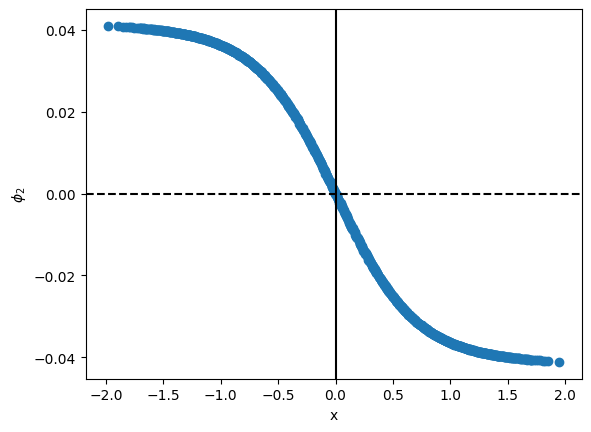

In [10]:
eigvecs_emp = eigvecs_emp.real
eigvecs_emp = eigvecs_emp/np.linalg.norm(eigvecs_emp,axis=0)
phi2_emp = eigvecs_emp[:,1]
sorted_indices = np.argsort(phi2_emp)
plt.scatter(centers[sorted_indices],phi2_emp[sorted_indices])
plt.ylabel(r'$\phi_2$')
plt.xlabel('x')
plt.axvline(0,c='k')
plt.axhline(0,c='k',ls='--')
plt.show()


We see that the leading eigenvector cleanly separates the two potential wells, confirming that the dominant slow process is hopping between metastable states. This provides a principled, data-driven way of identifying coarse-grained dynamical states.


Given $\phi_2$, we can now proceed as in [Notebook 1](https://https://colab.research.google.com/github/AntonioCCosta/DPG_PhysicsBehavior_2026/blob/main/notebooks/notebook_1_theory_dw.ipynb) and find the location of the energy barrier by maximizing the overall coherence of metastable sets along $\phi_2$.

In [11]:
inv_measure_emp = op_calc.stationary_distribution(P_emp)
cr,rho_sets,ms,idx,km_labels = cgm.optimal_partition(phi2_emp,inv_measure_emp,P_emp,return_rho=True)

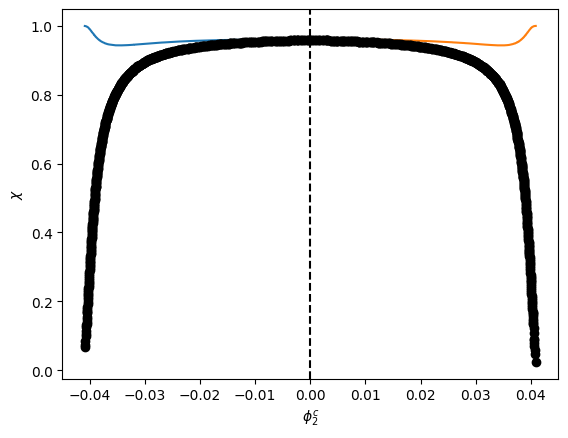

In [12]:
plt.plot(cr,rho_sets)
plt.plot(cr,np.min(rho_sets,axis=1),marker='o',c='k')
plt.axvline(cr[idx],c='k',ls='--')
plt.ylabel(r'$\chi$')
plt.xlabel(r'$\phi_2^c$')
plt.show()

As you can see, our entirely data-driven calculation recovers the slow modes of the dynamics, as well as the location of the energy barrier.

### Conceptual summary

Starting from raw trajectory data, we constructed a data-driven approximation of the transfer operator governing stochastic dynamics. Its spectral decomposition revealed a clear separation of timescales, allowing us to identify metastable states and construct a principled coarse-graining of the dynamics. This workflow provides a general framework for extracting low-dimensional behavioral descriptions from complex, high-dimensional data. In the next notebook ([Notebook 3](https://colab.research.google.com/github/AntonioCCosta/DPG_PhysicsBehavior_2026/blob/main/notebooks/notebook_3_Lorenz.ipynb)) we will move beyond 1d equilibrium dynamics, for which the slow modes of the dynamics are far less obvious even when we know the equations of motion.


# Appendix 1 - $\tau$ selection

Since we are working with discretely sampled dynamics and a discrete time operator $P_\tau$, instead of the underlying infinitesimal operator $L$ introduced in [Notebook 1](https://colab.research.google.com/github/AntonioCCosta/DPG_PhysicsBehavior_2026/blob/main/notebooks/notebook_1_theory_dw.ipynb), we have to be careful in our selection of $\tau$ to preserve the transition dynamics.

Intuitively, once we discretize the state space, setting $\tau→0$ may be dangerous because we may enter a pathological numerical limit in which the transition matrix approaches an identity matrix: we don't leave enough time for the state to leave a partition. In the opposite limit, when $\tau$ is much larger than the mixing time of the dynamics, the transition matrix will essentially contain copies of the steady state distribution $\pi$ since the time between $s_i$ and $s_j$ is too long: $P_{ij}(\tau→\infty) \sim \pi$. In this limit, all eigenvalues except for the eigenvalue 1 tend to zero. However, due to finite data, the estimated transition probabilities will deviate from the true invariant density, resulting in a set of small but non-zero eigenvalues that become independent of $\tau$ when it is much larger that the mixing time.

For intermediate $\tau$ we should find an appropriate spectral gap that separates the slow transition among wells, from the relaxation to the single well. In addition, the Markovian nature of the dynamics implies that the inferred relaxation times reach a constant value that matches the eigenvalues of the underlying dynamics $\Lambda_k^{-1}$: the Chapman-Kolmogorov equation is verified $P_{n\tau}\rho = P^n_\tau\rho$, and thus $t^\text{imp}_k(n\tau)=\frac{-n\tau}{\log (\lambda_k(\tau)^n)}=t^\text{imp}_k( \tau)$. We choose $\tau^*$ in this intermediate regime, such that $t^\text{imp}_k$ is approximately constant and we have large spectral gap.


By studying how the leading eigenvalues depend on the lag time $\tau$, we can directly probe the hierarchy of dynamical timescales. In metastable systems, slow relaxation modes persist over a wide range of $\tau$, reflecting rare barrier-crossing events separating long-lived states. Let's estimate the eigenvalues $\lambda_k$ and implied timescales $t^\text{imp}_k$ as a function of the delay $\tau$.



In [13]:
delay_range = np.unique(np.array(np.logspace(0,2.75,20),dtype=int))
n_modes=10
eigvals_delay = np.zeros((delay_range.shape[0],n_modes))
tscales_delay = np.zeros((delay_range.shape[0],n_modes))
for kd,delay in enumerate(delay_range):
  P_emp = op_calc.transition_matrix(labels_all,delay)
  R = op_calc.get_reversible_transition_matrix(P_emp) #ensure reversibility
  eigvals = op_calc.sorted_spectrum(R,k=n_modes+1)[0]
  sorted_indices = np.argsort(eigvals.real)[::-1]
  lambdas = eigvals[sorted_indices][1:].real
  eigvals_delay[kd,:] = lambdas
  tscales_delay[kd,:] = -delay*final_dt/np.log(lambdas)
  print(delay)

1
2
3
5
7
10
14
20
28
39
54
76
106
148
206
288
402
562


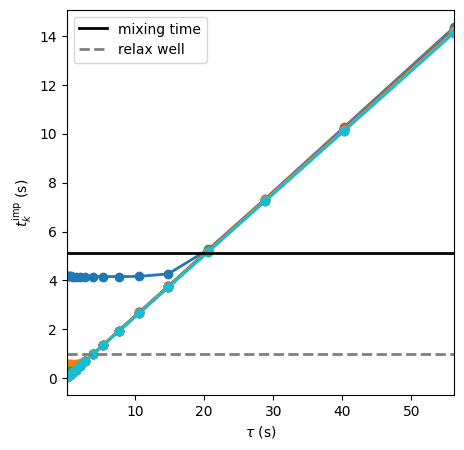

In [20]:
plt.figure(figsize=(5,5))
plt.plot(delay_range*final_dt,tscales_delay,lw=2,marker='o')
plt.axhline(1/(2*kramers_rate(mu,Tx)),c='k',lw=2,label='mixing time')
plt.axhline(1,c='gray',lw=2,ls='--',label='relax well')
plt.xlim(delay_range[0]*final_dt,delay_range[-1]*final_dt)
plt.xlabel(r'$\tau$ (s)')
plt.ylabel(r'$t^\text{imp}_k$ (s)')
plt.legend()
plt.show()

As you can see above, the implied timescales of the operator start relatively constant, indicating that our sampling time is large enough to enable meaningful transitions among our fine $N=1000$ partitions. In addition, we see that for large $\tau$ the implied timescales grow linearly with $\tau$: we enter the regime in which these fast modes have mixed, and the eigenvalues become constant, and so $t^\text{imp}_k(\tau) \sim \tau$.

For $0.1\text{s}<\tau<7\text{s}$ we see that the slowest timescale is close to the Kramers' estimate and approximately constant, which indicates that the slow dynamics are Markovian in that regime according to the Chapman-Kolmogorov identity. Beyond $\tau \sim 1\text{s}$, all fast modes (corresponding to the relaxtion to each well) mix and their corresponding implied timescale grow linearly.

Analysing these curves thus lays bare the multiscale strucuture of the dynamics, and the appropriate coarse-graining needed at different timescales.

To illustrate the large time limit and the deviation from $\lambda_k(\tau→0)=0$, we can also plot the eigenvalues as a function of $\tau$. You can see that the inferred eigenvalues converge to a non-zero noise floor.

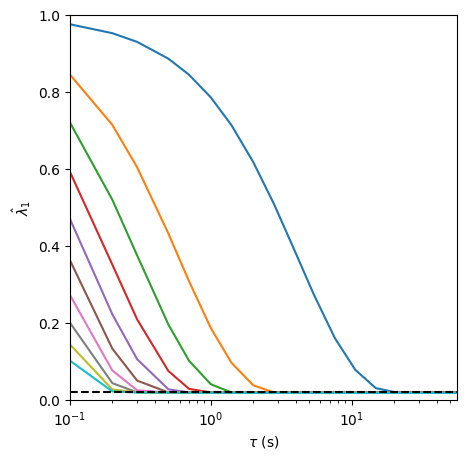

In [25]:
plt.figure(figsize=(5,5))
plt.plot(delay_range*final_dt,eigvals_delay)
plt.xscale('log')
plt.xlim(delay_range[0]*final_dt,delay_range[-1]*final_dt)
plt.xlabel(r'$\tau$ (s)')
plt.ylabel(r'$\hat{\lambda}_1$')
plt.axhline(eigvals_delay[-1,0],c='k',ls='--')
plt.ylim(0,1)
plt.show()

# Appendix 2 - Coarse-grained model

For $\tau⪆0.5\,\text{s}$, faster decaying fluctuations have relaxed, and we should be able to construct a coarse-grained 2-state Markov model that averages out fast fluctuating and captures the slow transitions amogn metastable states. This mirrors how macroscopic thermodynamic descriptions emerge from microscopic dynamics.

Let's test by estimating a coarse-grained transition matrix and making simulations.

In [16]:
label_traj=km_labels[labels_all]
delay=5
Pc = op_calc.transition_matrix(label_traj,delay)

In [17]:
from joblib import Parallel, delayed

def simulate(P,state0,iters):
    '''
    Monte Carlo simulation of the markov chain characterized by the matrix P
    state0: initial system
    iters: number of iterations of the simulation
    '''
    states = np.zeros(iters,dtype=int)
    states[0]=state0
    state=state0
    for k in range(1,iters):
        new_state = np.random.choice(np.arange(P.shape[1]),p=list(P[state,:]))
        state=new_state
        states[k]=state
    return states

n_sims=500
state0s = np.random.choice([0,1],n_sims)
n_iters=2000

sims_coarse = Parallel(n_jobs=-1)(delayed(simulate)(Pc.toarray(),state0,n_iters) for state0 in state0s)

In [18]:
all_durs = np.hstack([np.hstack(state_lifetime(ma.array(sim),final_dt*delay)) for sim in sims_coarse])

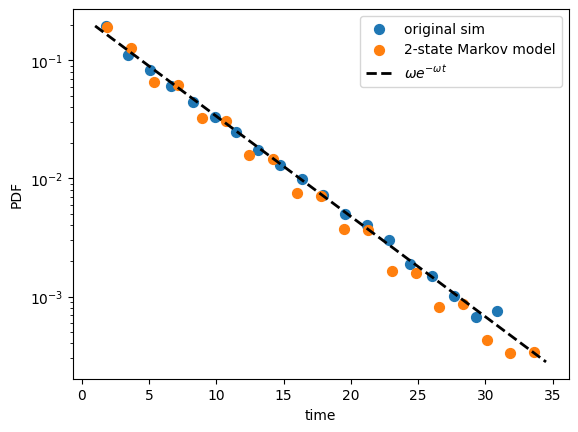

In [19]:
tmin=1
tmax=np.percentile(durs,99.9)
freqs,bin_edges = np.histogram(durs, bins=np.linspace(tmin,tmax,20), density=True)
centers_t = (bin_edges[1:]+bin_edges[:-1])/2
plt.scatter(centers_t,freqs,marker='o',s=50,label='original sim')

tmax=np.percentile(all_durs,99.9)

freqs,bin_edges = np.histogram(all_durs, bins=np.linspace(tmin,tmax,20), density=True)
centers_t = (bin_edges[1:]+bin_edges[:-1])/2
plt.scatter(centers_t,freqs,marker='o',s=50,label='2-state Markov model')

times = np.linspace(tmin,tmax,100)
_,b=np.polyfit(centers_t,np.log(freqs),1) #just to get the offset
rate = 2*kramers_rate(mu,Tx) #2x because it's only the time to the boundary
plt.plot(times,np.exp(b)*np.exp(-rate*times),c='k',lw=2,ls='--',label=r'$\omega e^{-\omega t}$')
plt.yscale('log')
plt.ylabel('PDF')
plt.xlabel('time')
plt.legend()
plt.show()